In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import os
import sqlite3

# Preprocessing
#from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

# Model
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
import optuna
import shap
import joblib
import keras

from scripts.config import DATA_PATH, MODELS_PATH

%load_ext autoreload
%autoreload 2

%load_ext tensorboard

from tempfile import mkdtemp
# Create a temp folder
cachedir = mkdtemp()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# 1. Import processed data

In [9]:
preprocess_version = 'v5'

data_dir = os.path.join(DATA_PATH, preprocess_version, 'classic')

X_past_train = np.load(os.path.join(data_dir, 'X_past_train.npy'))
X_future_train = np.load(os.path.join(data_dir, 'X_future_train.npy'))
X_past_val = np.load(os.path.join(data_dir, 'X_past_val.npy'))
X_future_val = np.load(os.path.join(data_dir, 'X_future_val.npy'))
X_past_test = np.load(os.path.join(data_dir, 'X_past_test.npy'))
X_future_test = np.load(os.path.join(data_dir, 'X_future_test.npy'))

X_past_train_transformed = np.load(os.path.join(data_dir, 'X_past_train_transformed.npy'))
X_future_train_transformed = np.load(os.path.join(data_dir, 'X_future_train_transformed.npy'))
X_past_val_transformed = np.load(os.path.join(data_dir, 'X_past_val_transformed.npy'))
X_future_val_transformed = np.load(os.path.join(data_dir, 'X_future_val_transformed.npy'))
X_past_test_transformed = np.load(os.path.join(data_dir, 'X_past_test_transformed.npy'))
X_future_test_transformed = np.load(os.path.join(data_dir, 'X_future_test_transformed.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
y_val = np.load(os.path.join(data_dir, 'y_val.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy'))

train_past_times = pd.read_pickle(os.path.join(data_dir, 'train_past_times.pkl'))
train_future_times = pd.read_pickle(os.path.join(data_dir, 'train_future_times.pkl'))

val_past_times = pd.read_pickle(os.path.join(data_dir, 'val_past_times.pkl'))
val_future_times = pd.read_pickle(os.path.join(data_dir, 'val_future_times.pkl'))
test_past_times = pd.read_pickle(os.path.join(data_dir, 'test_past_times.pkl'))
test_future_times = pd.read_pickle(os.path.join(data_dir, 'test_future_times.pkl'))

train_future_window_dates = pd.read_pickle(os.path.join(data_dir, 'train_future_window_dates.pkl'))
val_future_window_dates = pd.read_pickle(os.path.join(data_dir, 'val_future_window_dates.pkl'))
test_future_window_dates = pd.read_pickle(os.path.join(data_dir, 'test_future_window_dates.pkl'))   


In [10]:
train_future_window_dates.min(), train_future_window_dates.max()

(Timestamp('2015-01-12 12:00:00+0100', tz='Europe/Paris'),
 Timestamp('2023-12-31 12:00:00+0100', tz='Europe/Paris'))

In [11]:
val_future_window_dates.min(), val_future_window_dates.max()

(Timestamp('2024-01-16 12:00:00+0100', tz='Europe/Paris'),
 Timestamp('2024-12-31 12:00:00+0100', tz='Europe/Paris'))

/home/ronan/code/Power_Price_Forecasting/research/scripts/preprocess_v3.py:734: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Month'] = df['datetime'].dt.to_period('M')


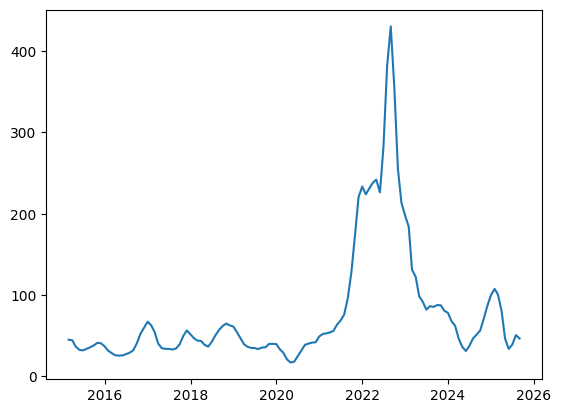

In [12]:
model_data = pd.read_csv(os.path.join(data_dir, '..', 'model_data.csv'))

from scripts.preprocess_v3 import monthly_statistics

monthly_stats = monthly_statistics(model_data)

plt.plot(monthly_stats.index, monthly_stats['3-Month Rolling Average'])

# 2. Forecast with ATT

In [13]:
from scripts.model_att_v2log import AttentionModel

att_model = AttentionModel(
    preprocess_version=preprocess_version,
    # CNN parameters
    cnn_filters=32,        # Increased to capture more complex patterns
                          # Start with more filters since we have 21 input features

    # LSTM parameters
    lstm_units=64,       # Increased to handle complex temporal dependencies
                         # Rule of thumb: 2-4x input features

    # Attention parameters
    attention_heads=4,    # Increased to capture different aspects of the sequence
                         # Rule of thumb: sequence_length / 32 ≈ 5-8
    attention_key_dim=32, # Typically key_dim = filters/heads for stable training
                         # 64/8 = 8 dimensions per head

    # Input dimensions (from your data)
    n_past_features=X_past_train_transformed.shape[2],   # From X_past_train_transformed.shape[2]
    n_future_features=X_future_train_transformed.shape[2], # From X_future_train_transformed.shape[2]
    past_seq_len=X_past_train_transformed.shape[1],     # From X_past_train_transformed.shape[1]
    future_seq_len=X_future_train_transformed.shape[1],    # From X_future_train_transformed.shape[1]

    # Regularization
    dropout=0.2,          # Slightly reduced to prevent underfitting
                         # Since we have batch_normalization
    batch_normalization=True,

    # Training parameters
    learning_rate=0.001,  # Good starting point for Adam
    verbose=True,
    epochs_early_stopping=20,  # Increased to allow better convergence
                              # Given the model complexity

    # Loss and metrics
    loss='mse',          # Appropriate for regression
    metrics=['mae'],     # Consider adding 'mape' for percentage error

    # Additional regularization
    regularization='l2', # Added L2 regularization
    lambda_reg=0.01,    # Small L2 penalty to prevent overfitting
    ar_lags=X_past_train_transformed.shape[1],
    mlflow_enabled=True,
    mlflow_nested=False

)


# ar_lags=X_past_train_transformed.shape[1]

att_model

2025/09/24 21:54:28 INFO mlflow.tracking.fluent: Experiment with name 'French_DAM_PowerPriceForecasting' does not exist. Creating a new experiment.


2025/09/24 21:54:31 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


Epoch 1/1000


2025-09-24 21:54:38.762160: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 12.6306 - mae: 2.3759

2025/09/24 21:54:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - loss: 12.5674 - mae: 2.3632 - val_loss: 9.0297 - val_mae: 1.9505 - learning_rate: 0.0010
Epoch 2/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 4.3806 - mae: 0.5537

2025/09/24 21:55:04 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 4.3777 - mae: 0.5530 - val_loss: 6.1438 - val_mae: 1.3202 - learning_rate: 0.0010
Epoch 3/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 3.7257 - mae: 0.4360

2025/09/24 21:55:16 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - loss: 3.7241 - mae: 0.4359 - val_loss: 5.7713 - val_mae: 1.3903 - learning_rate: 0.0010
Epoch 4/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 3.2361 - mae: 0.3923

2025/09/24 21:55:28 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - loss: 3.2363 - mae: 0.3930 - val_loss: 4.0983 - val_mae: 0.8437 - learning_rate: 0.0010
Epoch 5/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 3.0379 - mae: 0.4547

2025/09/24 21:55:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - loss: 3.0359 - mae: 0.4543 - val_loss: 3.9691 - val_mae: 1.0083 - learning_rate: 0.0010
Epoch 6/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 2.6383 - mae: 0.4000

2025/09/24 21:55:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - loss: 2.6376 - mae: 0.4002 - val_loss: 3.7496 - val_mae: 0.9321 - learning_rate: 0.0010
Epoch 7/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 2.3867 - mae: 0.3931 - val_loss: 4.6060 - val_mae: 1.2624 - learning_rate: 0.0010
Epoch 8/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 2.0715 - mae: 0.3398 - val_loss: 3.8013 - val_mae: 1.0325 - learning_rate: 0.0010
Epoch 9/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 1.8349 - mae: 0.3218

2025/09/24 21:56:23 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 1.8347 - mae: 0.3223 - val_loss: 2.8282 - val_mae: 0.8002 - learning_rate: 0.0010
Epoch 10/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 1.6446 - mae: 0.3387 - val_loss: 4.0565 - val_mae: 1.1625 - learning_rate: 0.0010
Epoch 11/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 1.5568 - mae: 0.3428 - val_loss: 2.9804 - val_mae: 1.0059 - learning_rate: 0.0010
Epoch 12/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 1.3002 - mae: 0.3072

2025/09/24 21:56:53 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 1.2999 - mae: 0.3073 - val_loss: 2.4311 - val_mae: 0.8083 - learning_rate: 0.0010
Epoch 13/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 1.1653 - mae: 0.3003 - val_loss: 2.7492 - val_mae: 0.9371 - learning_rate: 0.0010
Epoch 14/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 1.0402 - mae: 0.2999

2025/09/24 21:57:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 1.0399 - mae: 0.2999 - val_loss: 2.1316 - val_mae: 0.8087 - learning_rate: 0.0010
Epoch 15/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 0.9314 - mae: 0.2813 - val_loss: 2.2830 - val_mae: 0.9634 - learning_rate: 0.0010
Epoch 16/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - loss: 0.8940 - mae: 0.3163 - val_loss: 2.1321 - val_mae: 0.8750 - learning_rate: 0.0010
Epoch 17/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.7803 - mae: 0.2852

2025/09/24 21:57:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - loss: 0.7799 - mae: 0.2853 - val_loss: 1.7426 - val_mae: 0.7192 - learning_rate: 0.0010
Epoch 18/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 0.7400 - mae: 0.3093 - val_loss: 2.2017 - val_mae: 0.9080 - learning_rate: 0.0010
Epoch 19/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 0.6559 - mae: 0.2864 - val_loss: 2.2738 - val_mae: 0.9601 - learning_rate: 0.0010
Epoch 20/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 0.5432 - mae: 0.2537 - val_loss: 1.9371 - val_mae: 0.8768 - learning_rate: 0.0010
Epoch 21/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 0.5038 - mae: 0.2580 - val_loss: 1.8937 - val_mae: 0.8492 - learning_rate: 0.0010
Epoch 22/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.5440 - mae: 0.3336 - val_loss: 1.8790 - val_mae: 0.8415 - learning_rate: 0.0010
Epoch 23/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.4508 - mae: 0.2743

2025/09/24 21:58:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.4505 - mae: 0.2742 - val_loss: 1.5316 - val_mae: 0.7652 - learning_rate: 0.0010
Epoch 24/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4395 - mae: 0.2755

2025/09/24 21:58:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - loss: 0.4397 - mae: 0.2760 - val_loss: 1.2306 - val_mae: 0.6554 - learning_rate: 0.0010
Epoch 25/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 0.4151 - mae: 0.3070 - val_loss: 1.3025 - val_mae: 0.7188 - learning_rate: 0.0010
Epoch 26/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.3297 - mae: 0.2560

2025/09/24 21:59:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 0.3297 - mae: 0.2561 - val_loss: 1.0385 - val_mae: 0.6409 - learning_rate: 0.0010
Epoch 27/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.3573 - mae: 0.2797 - val_loss: 1.7139 - val_mae: 0.8486 - learning_rate: 0.0010
Epoch 28/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 0.2978 - mae: 0.2523 - val_loss: 1.6224 - val_mae: 0.8396 - learning_rate: 0.0010
Epoch 29/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.3059 - mae: 0.2735 - val_loss: 1.2100 - val_mae: 0.6957 - learning_rate: 0.0010
Epoch 30/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 0.2949 - mae: 0.2757 - val_loss: 1.4107 - val_mae: 0.7893 - learning_rate: 0.0010
Epoch 31/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 0.2669 - mae: 0.2619 - val_loss: 1.3197 - val_mae: 0.7256 - learning_rate: 0.0010
Epoch 32/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 0.2668 - mae: 0.2718 - val_loss: 1.4727 - val_mae: 0.7847 - learning_rate:

2025/09/24 22:00:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 0.2081 - mae: 0.2447 - val_loss: 0.9771 - val_mae: 0.6445 - learning_rate: 0.0010
Epoch 36/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.2038 - mae: 0.2482 - val_loss: 1.1762 - val_mae: 0.6927 - learning_rate: 0.0010
Epoch 37/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.2188 - mae: 0.2516 - val_loss: 1.0846 - val_mae: 0.6502 - learning_rate: 0.0010
Epoch 38/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.2063 - mae: 0.2494 - val_loss: 1.1580 - val_mae: 0.7391 - learning_rate: 0.0010
Epoch 39/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 0.2454 - mae: 0.2848 - val_loss: 1.4100 - val_mae: 0.7935 - learning_rate: 0.0010
Epoch 40/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 0.2116 - mae: 0.2666 - val_loss: 1.1840 - val_mae: 0.7198 - learning_rate: 0.0010
Epoch 41/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 0.1942 - mae: 0.2548 - val_loss: 1.4908 - val_mae: 0.8147 - learning_rate:

2025/09/24 22:04:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: cannot import name 'storage' from 'google.cloud' (unknown location)


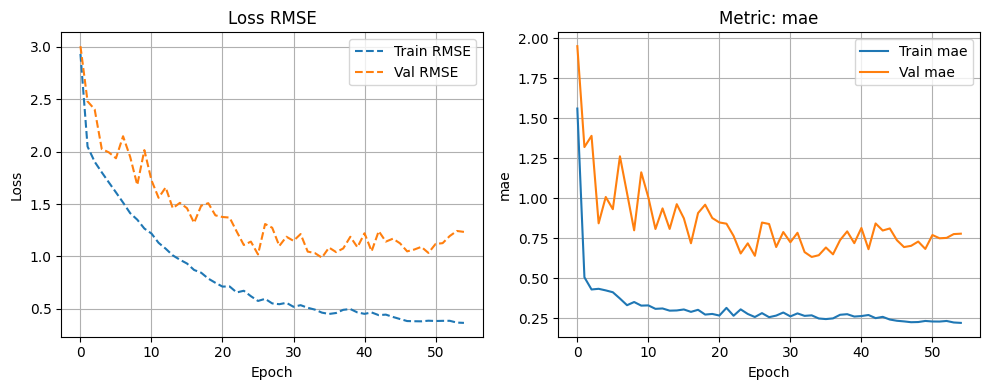

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.9604 - mae: 0.6418
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1424 - mae: 0.1859

Final Training Metrics (training space):
RMSE: 0.4217
['mae']: [0.2084822952747345]

Final Validation Metrics (training space):
RMSE: 0.9885
['mae']: [0.6444944143295288]

Final Training Metrics (original scale):
RMSE: 30.9272
['mae']: [17.812887265179338]

Final Validation Metrics (original scale):
RMSE: 32.1908
['mae']: [25.168159426173585]
🏃 View run ATT_v2log_preproc_v5_20250924_215426 at: https://mlflow-1040927723543.europe-west1.run.app/#/experiments/1/runs/7c2b2653d2e44c079922ddeafc861fb4
🧪 View experiment at: https://mlflow-1040927723543.europe-west1.run.app/#/experiments/1


ImportError: cannot import name 'storage' from 'google.cloud' (unknown location)

In [14]:
att_model.fit(X_past_train_transformed, X_future_train_transformed, y_train, 
            X_past_val_transformed, X_future_val_transformed, y_val)


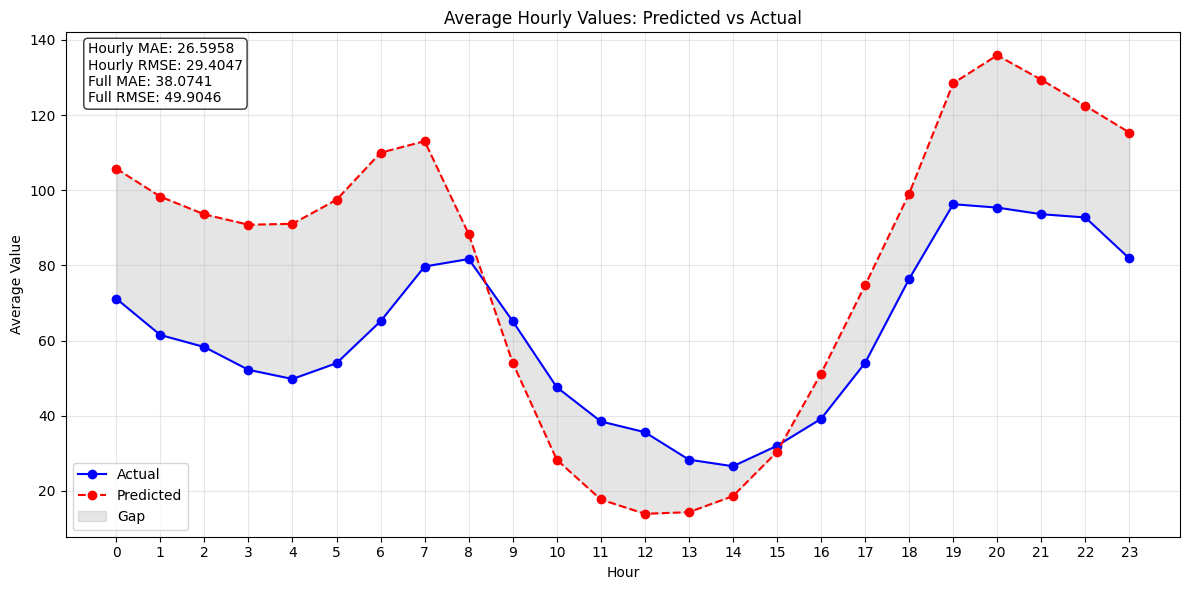

In [ ]:
pred = att_model.predict(X_past_test_transformed, X_future_test_transformed)

att_model.plot_hourly_averages(y_test, pred)

In [ ]:
data_dir = os.path.join(DATA_PATH, 'v5', 'classic')

X_past_2025 = np.load(os.path.join(data_dir, 'X_past_test.npy'))
X_future_2025 = np.load(os.path.join(data_dir, 'X_future_test.npy'))

X_past_2025_transformed = np.load(os.path.join(data_dir, 'X_past_test_transformed.npy'))
X_future_2025_transformed = np.load(os.path.join(data_dir, 'X_future_test_transformed.npy'))

y_2025 = np.load(os.path.join(data_dir, 'y_test.npy'))

past_times_2025 = pd.read_pickle(os.path.join(data_dir, 'test_past_times.pkl'))
future_times_2025 = pd.read_pickle(os.path.join(data_dir, 'test_future_times.pkl'))

future_window_dates_2025 = pd.read_pickle(os.path.join(data_dir, 'test_future_window_dates.pkl')) 

att_model.evaluate(X_past_2025_transformed, X_future_2025_transformed, y_2025)

{'eval_rmse_train_space': 1.2250143595262597,
 'eval_metrics_train_space': [0.8566209673881531],
 'rmse_original': 49.90455189502279,
 'mae_original': 38.07408066075017}

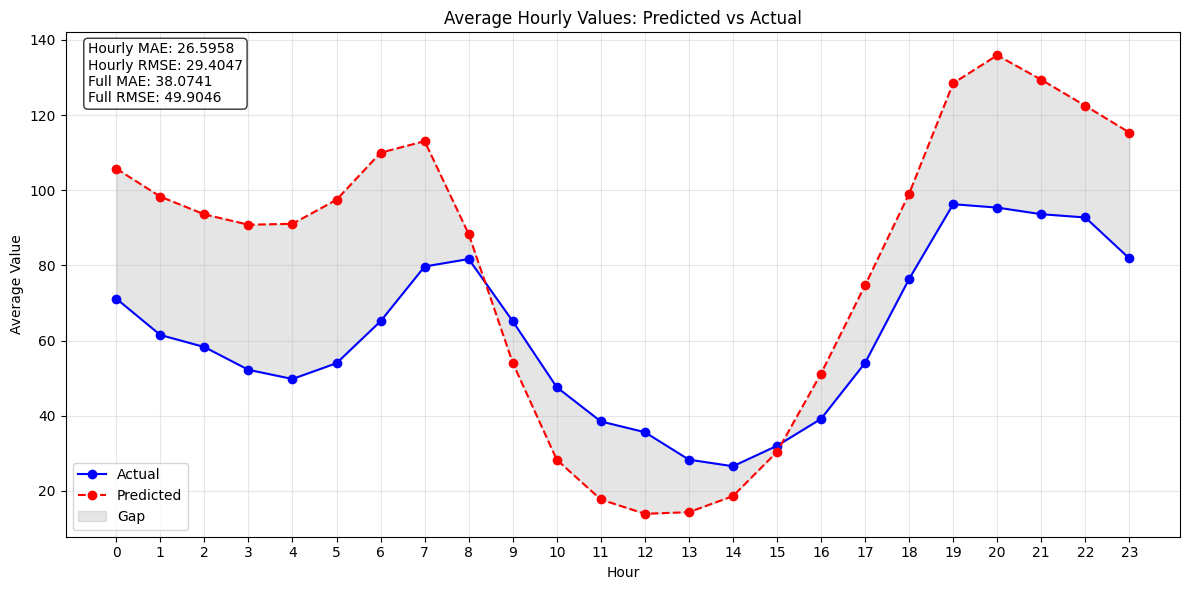

In [ ]:
pred = att_model.predict(X_past_2025_transformed, X_future_2025_transformed)

att_model.plot_hourly_averages(y_2025, pred)